In [26]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession \
    .builder \
    .appName("Learning Spark") \
    .getOrCreate()

In [13]:
df = spark.read.json("claims/*jsonl")

In [14]:
df.show()

+-------+-------------+--------------------+--------------------+--------------------+-------+
|  claim|      crawler|          scraped_at|                 url|                uuid|version|
+-------+-------------+--------------------+--------------------+--------------------+-------+
|131,996|ClaimsCrawler|2023-06-18 12:09:...|https://mx.comput...|7c9d6fab-4e91-4e1...|  0.0.1|
| 91.006|ClaimsCrawler|2023-06-18 12:09:...|https://co.comput...|5e5fc9c4-d289-41b...|  0.0.1|
|143,048|ClaimsCrawler|2023-06-18 12:09:...|https://www.occ.c...|5dc96ab1-211f-42c...|  0.0.1|
|133,346|ClaimsCrawler|2023-06-17 18:41:...|https://mx.comput...|6b83d3dc-4e56-4e4...|  0.0.1|
| 91.946|ClaimsCrawler|2023-06-17 18:41:...|https://co.comput...|5cc21ffc-220a-491...|  0.0.1|
|145,780|ClaimsCrawler|2023-06-17 18:41:...|https://www.occ.c...|99621388-20ef-46b...|  0.0.1|
| 131795|ClaimsCrawler|2023-06-18 16:00:...|https://mx.comput...|19bfd6ad-1d8b-4d4...|  0.0.2|
|  90939|ClaimsCrawler|2023-06-18 16:00:...|https:

In [15]:
df = df.where("version = '0.0.2'")
df.show()

+------+-------------+--------------------+--------------------+--------------------+-------+
| claim|      crawler|          scraped_at|                 url|                uuid|version|
+------+-------------+--------------------+--------------------+--------------------+-------+
|131795|ClaimsCrawler|2023-06-18 16:00:...|https://mx.comput...|19bfd6ad-1d8b-4d4...|  0.0.2|
| 90939|ClaimsCrawler|2023-06-18 16:00:...|https://co.comput...|55409c9a-c8e0-4aa...|  0.0.2|
|143063|ClaimsCrawler|2023-06-18 16:00:...|https://www.occ.c...|082e38b5-6379-46b...|  0.0.2|
| 90802|ClaimsCrawler|2023-06-18 20:00:...|https://co.comput...|1969e8f0-821f-46c...|  0.0.2|
|131675|ClaimsCrawler|2023-06-18 20:00:...|https://mx.comput...|4b32c5c0-befc-4a4...|  0.0.2|
|143082|ClaimsCrawler|2023-06-18 20:00:...|https://www.occ.c...|2a30674c-ca13-4da...|  0.0.2|
|131743|ClaimsCrawler|2023-06-19 00:00:...|https://mx.comput...|05bbb7db-af94-44d...|  0.0.2|
| 90820|ClaimsCrawler|2023-06-19 00:00:...|https://co.comput

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(-1.0, 0, '2023-06-19 12:00:48.239066'),
  Text(0.0, 0, '2023-06-18 16:00:44.927250'),
  Text(1.0, 0, '2023-06-18 20:00:44.329050'),
  Text(2.0, 0, '2023-06-19 00:00:48.557039'),
  Text(3.0, 0, '2023-06-19 04:00:45.723339'),
  Text(4.0, 0, '2023-06-19 08:00:45.075144'),
  Text(5.0, 0, '2023-06-19 12:00:48.239066'),
  Text(6.0, 0, '')])

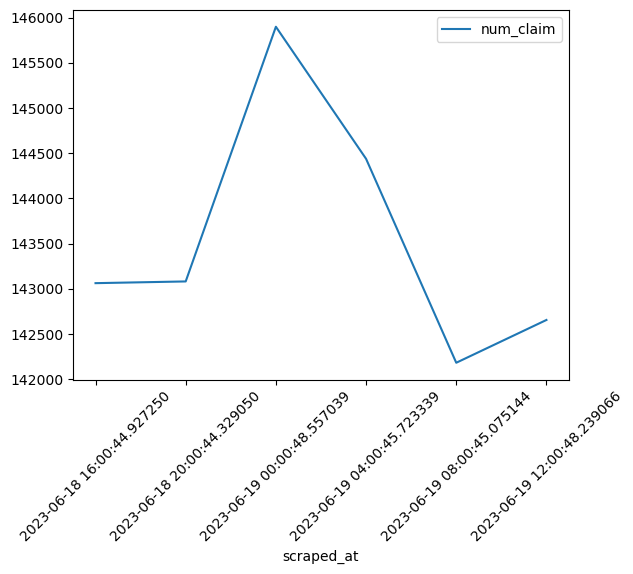

In [41]:
data = df.where(df.url.startswith("https://www.occ")).withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.xticks(rotation=45)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(-1.0, 0, '2023-06-19 12:00:46.065175'),
  Text(0.0, 0, '2023-06-18 16:00:43.678074'),
  Text(1.0, 0, '2023-06-18 20:00:43.296874'),
  Text(2.0, 0, '2023-06-19 00:00:44.627624'),
  Text(3.0, 0, '2023-06-19 04:00:44.317947'),
  Text(4.0, 0, '2023-06-19 08:00:43.498832'),
  Text(5.0, 0, '2023-06-19 12:00:46.065175'),
  Text(6.0, 0, '')])

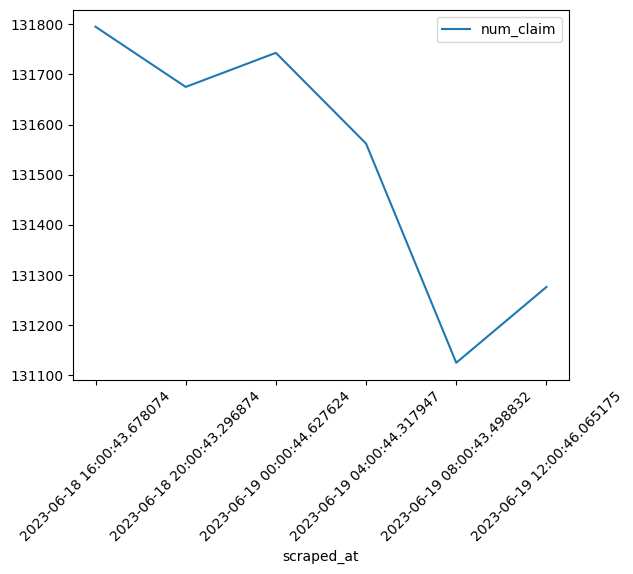

In [43]:
data = df.where(df.url.startswith("https://mx")).withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.xticks(rotation=45)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(-1.0, 0, '2023-06-19 12:00:46.152885'),
  Text(0.0, 0, '2023-06-18 16:00:43.758884'),
  Text(1.0, 0, '2023-06-18 20:00:43.215504'),
  Text(2.0, 0, '2023-06-19 00:00:44.708944'),
  Text(3.0, 0, '2023-06-19 04:00:44.398547'),
  Text(4.0, 0, '2023-06-19 08:00:43.579363'),
  Text(5.0, 0, '2023-06-19 12:00:46.152885'),
  Text(6.0, 0, '')])

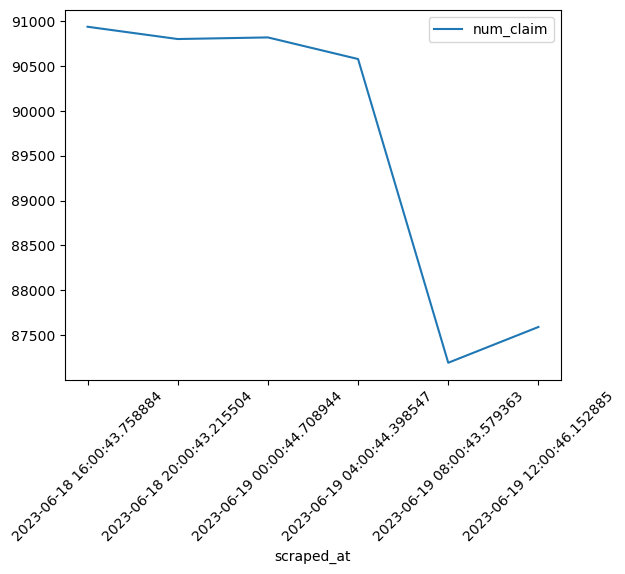

In [42]:
data = df.where(df.url.startswith("https://co")).withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.xticks(rotation=45)